Bazirano na radu https://proceedings.mlr.press/v139/xu21h/xu21h.pdf

The study introduces a **technique** for creating PIs **not bound by** any specific **distribution** for **dynamic
time series dat**a. The EnbPI method encompasses a** bootstrap ensemble estimator to formulate sequential
P**Is. Unlike classical conformal prediction methods that require data exchangeability, EnbP**I does not
require data exchangeabil**ity and has been custom-built for time series.
The data exchangeability assumption suggests that the sequence in which observations appear in the
dataset doesn’t matter. However, this assumption does not apply to time series, where the sequence
of data points is crucial. EnbPI doesn’t rely on data exchangeability, making it aptly suited for time
series analysis.
PIs generated by EnbPI attain a finite-sample, approximately valid marginal coverage for broad
regression functions and time series under the mild assumption of strongly mixing stochastic errors.
Additionally, EnbPI is computationally efficient and avoids overfitting by not requiring data splitting or
training multiple ensemble estimators. It is also scalable to producing arbitrarily many PIs sequentially
and is well suited to a wide range of regression functions.
Time series data is dynamic and often non-stationary, meaning the statistical properties can change
over time. While various regression functions exist for predicting time series, such as those using
boosted trees or neural network structures, these existing methods often need help constructing
accurate PIs. Typically, they can only create reliable intervals by placing restrictive assumptions on
the underlying distribution of the time series, which may only sometimes be appropriate or feasible

In [229]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, normalize, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

from fortuna.conformal import EnbPI
from fortuna.metric.regression import prediction_interval_coverage_probability

### Učitavanje podataka 

- CITY HOTEL : Lisabon, Hotel ID 1
- RESORT HOTEL: Algarve, Hotel ID 0

In [230]:
DATA_HOTEL0_BASE_PATH = '../data/interim/hotel_0'
DATA_HOTEL1_BASE_PATH = '../data/interim/hotel_1'
WEATHER_DATA_BASE_PATH = '../data/external/weather_data'
HOLIDAYS_BASE_PATH = '../data/external/holidays'


In [231]:
city_weather = pd.read_csv(os.path.join(WEATHER_DATA_BASE_PATH, 'lisbon//lisbon_weather_data.csv'))
resort_weather = pd.read_csv(os.path.join(WEATHER_DATA_BASE_PATH, 'algarve//algarve_weather_data.csv'))

In [232]:
portugal_holidays = pd.read_csv(os.path.join(HOLIDAYS_BASE_PATH, 'portugal//holidays.csv'))

In [233]:
NumberOfGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_arrivals.parquet"))

In [234]:
NumberOfGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_arrivals.parquet"))

#### Podaci na dnevnoj bazi City Hotel 

In [235]:
NumberOfArrivalsDailyCity = NumberOfArrivalsDailyCity.reset_index()

city_weather['datetime'] = pd.to_datetime(city_weather['datetime'], format='%Y-%m-%d')

daily_city_data = pd.merge(NumberOfArrivalsDailyCity, city_weather, left_on='datum_dolaska', right_on='datetime')


In [236]:
daily_city_data.drop(columns=['datetime','name','stations',], inplace=True)


In [237]:
portugal_holidays['date'] = pd.to_datetime(portugal_holidays['date'], format='%Y-%m-%d')
daily_city_data['datum_dolaska'] = pd.to_datetime(daily_city_data['datum_dolaska'])

daily_city_data = pd.merge(daily_city_data, portugal_holidays, left_on='datum_dolaska', right_on='date', how='left')
daily_city_data ['holiday'] = daily_city_data ['name'].notna()


In [238]:
daily_city_data['workingday'] = daily_city_data['datum_dolaska'].dt.dayofweek.isin(range(5)) & ~daily_city_data['holiday']


In [239]:
daily_city_data['year']  = daily_city_data['datum_dolaska'].dt.year
daily_city_data['month'] = daily_city_data['datum_dolaska'].dt.month
daily_city_data['day']   = daily_city_data['datum_dolaska'].dt.day

In [240]:
daily_city_data.drop(['date', 'name', 'type','severerisk','feelslikemax',
                      'feelslikemin','precipprob','precipcover',
                      'sunrise','sunset','moonphase','conditions','description',
                      'winddir',	'sealevelpressure',	'cloudcover',	'visibility',	
                      'solarradiation',	'solarenergy',	'uvindex',
                      'dew','humidity','preciptype','snow','snowdepth','windgust','windspeed',
                      'feelslike','datum_dolaska'
                      ], axis=1, inplace=True)


In [241]:
daily_city_data['icon'].unique()

array(['clear-day', 'partly-cloudy-day', 'rain', 'cloudy'], dtype=object)

In [242]:
daily_city_data.head()

,broj_dolazaka,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
0,6,86.098601,14.7,2.9,8.5,0.0,clear-day,True,False,2015,1,1
1,3,69.918070,12.6,2.3,7.9,0.0,partly-cloudy-day,False,True,2015,1,2
2,5,51.259983,13.9,4.2,8.6,0.0,clear-day,False,False,2015,1,3
3,5,69.173692,14.0,3.2,8.2,0.0,clear-day,False,False,2015,1,4
4,2,75.949916,12.4,2.4,7.6,0.0,clear-day,False,True,2015,1,5


#### Podaci na dnevnoj bazi Resort Hotel 

In [243]:
NumberOfArrivalsDailyResort = NumberOfArrivalsDailyResort.reset_index()

resort_weather['datetime'] = pd.to_datetime(resort_weather['datetime'], format='%Y-%m-%d')

daily_resort_data = pd.merge(NumberOfArrivalsDailyResort, resort_weather, left_on='datum_dolaska', right_on='datetime')


In [244]:
daily_resort_data.drop(columns=['datetime','name','stations',], inplace=True)


In [245]:
portugal_holidays['date'] = pd.to_datetime(portugal_holidays['date'], format='%Y-%m-%d')
daily_resort_data['datum_dolaska'] = pd.to_datetime(daily_resort_data['datum_dolaska'])

daily_resort_data = pd.merge(daily_resort_data, portugal_holidays, left_on='datum_dolaska', right_on='date', how='left')
daily_resort_data['holiday'] = daily_resort_data['name'].notna()


In [246]:
daily_resort_data.drop(['date', 'name', 'type'], axis=1, inplace=True)


In [247]:
daily_resort_data['workingday'] = daily_resort_data['datum_dolaska'].dt.dayofweek.isin(range(5)) & ~daily_resort_data['holiday']


In [248]:
daily_resort_data.head()

,datum_dolaska,broj_dolazaka,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,holiday,workingday
0,2015-07-01,32,57.719417,24.7,17.3,21.3,24.7,17.3,21.3,16.5,...,8,NaN,2015-07-01T06:15:36,2015-07-01T20:55:19,0.48,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,True,False
1,2015-07-02,35,68.548378,27.7,17.9,23.0,27.0,17.9,23.0,13.9,...,10,NaN,2015-07-02T06:16:03,2015-07-02T20:55:14,0.50,Clear,Clear conditions throughout the day.,clear-day,False,True
2,2015-07-03,27,59.951927,26.9,19.1,23.8,27.0,19.1,23.8,11.9,...,10,NaN,2015-07-03T06:16:32,2015-07-03T20:55:07,0.55,Clear,Clear conditions throughout the day.,clear-day,False,True
3,2015-07-04,36,54.928429,29.1,18.9,24.5,29.6,18.9,24.7,12.1,...,10,NaN,2015-07-04T06:17:02,2015-07-04T20:54:58,0.58,Clear,Clear conditions throughout the day.,clear-day,True,False
4,2015-07-05,37,59.883143,29.5,24.8,27.1,29.9,24.8,27.2,15.8,...,10,NaN,2015-07-05T06:17:32,2015-07-05T20:54:48,0.62,Clear,Clear conditions throughout the day.,clear-day,False,False


### Modeliranje

In [249]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]

#### City Hotel

In [285]:
y  = daily_city_data['broj_dolazaka'] / daily_city_data['broj_dolazaka'].max() 
#normalize(daily_city_data['broj_dolazaka'].values.reshape(-1, 1), axis=0)
X = daily_city_data.drop(columns=['broj_dolazaka'],axis="columns")
X_train, X_test = train_test_split(X, test_size=0.4, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.4, shuffle=False)

In [301]:
n_bs_samples = 40
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)
  

In [302]:
bs_indices.shape

(40, 661)

In [303]:
X_train.shape

(661, 11)

In [304]:
len(bs_train_data)

40

In [305]:
bs_train_data[0][0][0:2]

,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
516,57.523216,20.5,14.7,17.7,0.096,rain,False,True,2016,5,27
398,58.940000,16.5,11.3,13.1,0.000,partly-cloudy-day,False,True,2016,2,2


In [306]:
# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

Index([ 40, 541, 167, 256,  24, 484, 289, 170, 426, 535,
       ...
       343, 435, 428, 166,  66, 445,  35, 225, 188, 561],
      dtype='int64', length=408)


In [307]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
40,0.0,9.6,6.8,8.4,0.102,rain,False,True,2015,2,10
40,0.0,9.6,6.8,8.4,0.102,rain,False,True,2015,2,10


In [308]:
categorical_columns = ['icon','holiday','workingday']
categories = [
   ['clear-day', 'partly-cloudy-day', 'rain', 'cloudy'],
   [False, True],
   [False, True],
   ]

In [309]:
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns
    ),
).set_output(transform="pandas")

In [310]:
!set LOKY_MAX_CPU_COUNT=0 #change depeneding on the number of cores you want to use

In [311]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [312]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

- In order to evaluate conditional coverage, we measure the Prediction Interval Coverage Probability (PICP), i.e. the percentage of
 test target variables that actually falls within the conformal intervals. We further measure the percentage of intervals that contain the point
  predictions given by the model. Finally, we measure the size of the conformal intervals, which EnbPI takes to be the same for every intervals
 if no online feedback is provided, like in this case.
     

In [313]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8027210831642151.
Size of the conformal intervals: 0.371801495552063


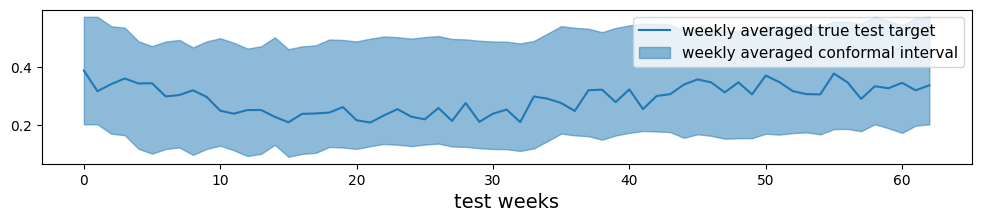

In [314]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
     


EnbPI with online feedback

In [315]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

Similarly as done above, we compute the percentage of predictions and true test targets falling within the conformal intervals. Again, it is good to see that all conformal intervals include the point predictions. Also, the percentage of intervals containing the true targets increased to around 83%, getting closer to the desired coverage of 95%.

In [316]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8730158805847168.


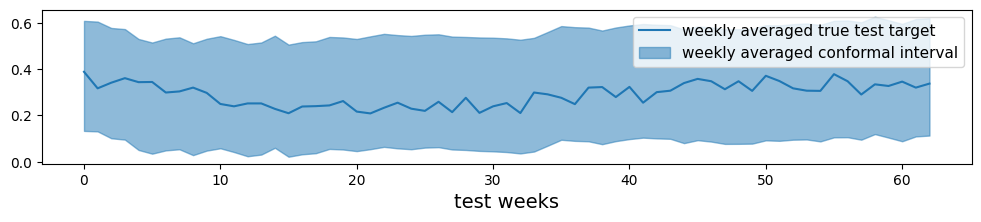

In [317]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

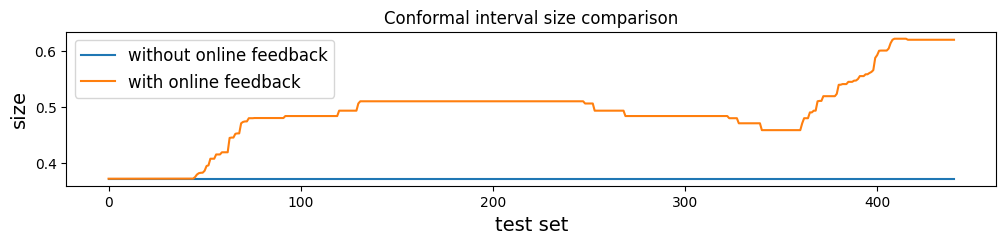

In [318]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

#### Resort Hotel